In [1]:
from itertools import combinations
from collections import namedtuple
import numpy as np
from jax import hessian, jacfwd, jacrev, jit
from scipy.linalg import eig

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import sys
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
from ipywidgets.widgets import HBox, VBox, Label

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *

In [2]:
import jax.numpy as jnp


def L2_mean(x):
    return jnp.mean((x)**2)

def root_L2_mean(x):
    return jnp.sqrt(L2_mean(x))

def create_u_residual(c, c_xx, c_yy, c_t):
    u = c[0, ...]
    v = c[1, ...]
    u_xx = c_xx[0, ...]
    u_yy = c_yy[0, ...]
    u_t = c_t[0, ...]
    
    def res_u(D_u, kappa_u, rho_u, mu_u, sigma_u):        
        f = u * u * v / (1.0 + kappa_u * u * u)    
        return D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u - u_t
    return res_u

def create_v_residual(c, c_xx, c_yy, c_t):
    u = c[0, ...]
    v = c[1, ...]
    v_xx = c_xx[1, ...]
    v_yy = c_yy[1, ...]
    v_t = c_t[1, ...]    
    
    def res_v(D_v, kappa_u, rho_v, sigma_v):
        f = u * u * v / (1.0 + kappa_u * u * u)    
        return D_v * (v_xx + v_yy) - rho_v * f + sigma_v - v_t
    
    return res_v

def create_loss(c, c_xx, c_yy, c_t):
    res_u = create_u_residual(c, c_xx, c_yy, c_t)
    res_v = create_v_residual(c, c_xx, c_yy, c_t)
    def loss(D_u, D_v, kappa_u, rho_u, mu_u, sigma_u, rho_v, sigma_v):        
        return res_u(D_u, kappa_u, rho_u, mu_u, sigma_u) + res_v(D_v, kappa_u, rho_v, sigma_v)
    
    return loss

def create_l2_loss(c, c_xx, c_yy, c_t):    
    l = create_loss(c, c_xx, c_yy, c_t)
    def l2_loss(D_u, D_v, kappa_u, rho_u, mu_u, sigma_u, rho_v, sigma_v):
        return L2_mean(l(D_u, D_v, kappa_u, rho_u, mu_u, sigma_u, rho_v, sigma_v))
    
    return l2_loss

def residuals(c, c_xx, c_yy, c_t, simulation):
     
    u = c[0, ...]
    v = c[1, ...]
    u_xx = c_xx[0, ...]
    u_yy = c_yy[0, ...]
    u_t = c_t[0, ...]
    v_xx = c_xx[1, ...]
    v_yy = c_yy[1, ...]
    v_t = c_t[1, ...]    
    
    D_u = simulation.Ds[0] 
    D_v = simulation.Ds[1]
    kappa_u = simulation.parameters['kappa_u']
    rho_u = simulation.parameters['rho_u']
    mu_u = simulation.parameters['mu_u']
    sigma_u = simulation.parameters['sigma_u']
    rho_v = simulation.parameters['rho_v']
    sigma_v = simulation.parameters['sigma_v']
    
    f = u * u * v / (1.0 + kappa_u * u * u)
    
    res_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u - u_t
    res_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v - v_t
    return (res_u, res_v)

symbols = {"D_u": "D_u", "D_v": "D_v", "kappa_u": r"\kappa_u", 
            "rho_u":r"\rho_u", "rho_v":r"\rho_v", "mu_u":r"\mu_u",
            "sigma_u":r"\sigma_u", "sigma_v":r"\sigma_v"}

In [3]:
Pattern = namedtuple('Pattern', ['simulation', 't_star', 'x_size', 'y_size', 
                                 'c', 'c_xx', 'c_yy', 'c_t',
                                 'c_domain', 'c_xx_domain', 'c_yy_domain', 'c_t_domain',
                                 'params', 'u_params', 'v_params',
                                 'l2_loss', 'loss_u', 'loss_v'])             

def load(sim_name, 
         x_slice,
         y_slice,
         data_time_start=-3, 
         data_time_len=2,
         data_time_step=1,
         verbose=False
        ):
    data_path = os.path.abspath(f"../../test/outputs_Koch_Meinhardt_100_by_100/{sim_name}/{sim_name}.npy")
    with open(data_path, 'rb') as f:
        data = np.load(f)

    data_path = os.path.abspath(f"../../test/outputs_Koch_Meinhardt_100_by_100/{sim_name}/simulation.txt")
    with open(data_path, 'r') as f:
        simulation = eval(f.read())
        
    t_star = np.linspace(simulation.t_start, 
                     simulation.t_end, 
                     simulation.t_steps)
    
    if verbose:
        print(f"Initial dataset shape was: {data.shape}.")
    
    L = simulation.L[0]
    x_size = data.shape[1]
    y_size = data.shape[2]
    N = x_size*y_size    
    dxdy = x_size*y_size/L**2
    
       
    if data_time_start+data_time_len+1 < 0:
        time_slice=slice(data_time_start, data_time_start+data_time_len+1, data_time_step)
    else:
        time_slice=slice(data_time_start, data.shape[3], data_time_step)
    data_time_slice=slice(data_time_start, data_time_start+data_time_len, data_time_step)
    
    data_time = data[:, :, :, time_slice].copy()
    data = data[:, :, :, data_time_slice] 
    
    if verbose:
        print(f"It reduced to: {data.shape}.")
    
    t_star_time = t_star[time_slice].copy()
    t_star = t_star[data_time_slice]
    
    assert len(t_star) > 1, f"There must be at least two time steps. There are '{len(t_star)}'."
    
    c_xx =  np.array([[ dxdy  * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
    c_xx = np.einsum("ctij -> cijt", c_xx)
    c_yy = np.array([[ dxdy * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
    c_yy = np.einsum("ctij -> cijt", c_yy)

    c_t = np.array([[(data_time[c, ..., t+1] -  data_time[c, ..., t])/(t_star_time[t+1] - t_star_time[t])
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
    c_t = np.einsum("ctij -> cijt", c_t)
    
    diff_Y = np.array([[dxdy * diffusion((x_size,y_size), data[c, ..., t]) 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
    diff_Y = np.einsum("ctij -> cijt", diff_Y)
        
    if verbose:
        print(f"And its X-Y size reduced to: {data[:, x_slice, y_slice, :].shape}.")
        
        
    
        
    params = {"D_u": simulation.Ds[0],
          "D_v": simulation.Ds[1],
          "kappa_u": simulation.parameters["kappa_u"],
          "rho_u": simulation.parameters["rho_u"],
          "mu_u": simulation.parameters["mu_u"],
          "sigma_u": simulation.parameters["sigma_u"],
          "rho_v": simulation.parameters["rho_v"],
          "sigma_v": simulation.parameters["sigma_v"]}
    
    u_params = {k: params[k] for k in ("D_u", "kappa_u", "rho_u", "mu_u", "sigma_u")}
    v_params = {k: params[k] for k in ("D_v", "kappa_u", "rho_v", "sigma_v")}
    
    c_restricted = data[:, x_slice, y_slice, :]
    c_xx_restricted = c_xx[:, x_slice, y_slice, :]
    c_yy_restricted = c_yy[:, x_slice, y_slice, :] 
    c_t_restricted = c_t[:, x_slice, y_slice, :]
    
    
    l2_loss =create_l2_loss(jnp.asarray(c_restricted),
                            jnp.asarray(c_xx_restricted),
                            jnp.asarray(c_yy_restricted),
                            jnp.asarray(c_t_restricted))
    
    loss_u = create_u_residual(jnp.asarray(c_restricted),
                           jnp.asarray(c_xx_restricted),
                           jnp.asarray(c_yy_restricted),
                           jnp.asarray(c_t_restricted))
    loss_v = create_v_residual(jnp.asarray(c_restricted),
                           jnp.asarray(c_xx_restricted),
                           jnp.asarray(c_yy_restricted),
                           jnp.asarray(c_t_restricted))
        
    pattern = Pattern(simulation, t_star, x_size, y_size, 
                      c_restricted, c_xx_restricted, c_yy_restricted, c_t_restricted, 
                      data, c_xx, c_yy, c_t,
                      params, u_params, v_params,
                      l2_loss, loss_u, loss_v)
        
    return pattern


In [4]:
x_slice=slice(30,65,5)
y_slice=slice(50,85,5)    
pattern = load("Koch_Meinhardt_1", 
               x_slice,
               y_slice,
               data_time_start=-3, 
               data_time_len=2,
               data_time_step=1,
               verbose=False)

In [5]:
pattern.l2_loss(pattern.simulation.Ds[0], pattern.simulation.Ds[1],
                pattern.simulation.parameters["kappa_u"],
                pattern.simulation.parameters["rho_u"],
                pattern.simulation.parameters["mu_u"],
                pattern.simulation.parameters["sigma_u"],
                pattern.simulation.parameters["rho_v"],
                pattern.simulation.parameters["sigma_v"])

Array(7.5354767e-13, dtype=float32)

In [6]:
pattern.loss_u(pattern.simulation.Ds[0], 
                pattern.simulation.parameters["kappa_u"],
                pattern.simulation.parameters["rho_u"],
                pattern.simulation.parameters["mu_u"],
                pattern.simulation.parameters["sigma_u"]).shape

(7, 7, 2)

In [23]:
pattern = None
def load_domain(simulation_name, x_range=(30, 65), y_range=(50, 85), steps=10, title_1="u", title_2="v"):
    disable_all_ranges(True)
    def plot_d(d, title_1="u", title_2="v"):
        x = np.arange(0, d[0,:,:, -1].T.shape[0])[x_slice]
        y = np.arange(0, d[0,:,:, -1].T.shape[1])[y_slice]
        X, Y = np.meshgrid(x, y, indexing='ij')
        _ = plt.figure(figsize=(8,4))
        plt.subplot(121)
        plt.title(f"{title_1}")
        plt.imshow(d[0,:,:, -1].T, origin='lower')
        plt.colorbar(shrink=.75)
        plt.scatter(X, Y, alpha=.5)
        plt.subplot(122)
        plt.title(f"{title_2}")
        plt.imshow(d[1,:,:, -1].T, origin='lower')
        plt.colorbar(shrink=.75)
        plt.scatter(X, Y, alpha=.5)    
        plt.show()
        
    
    x_slice=slice(x_range[0],x_range[1],steps)
    y_slice=slice(y_range[0],y_range[1],steps)    
    pattern = load(simulation_name, 
                   x_slice,
                   y_slice,
                   data_time_start=-3, 
                   data_time_len=2,
                   data_time_step=1,
                   verbose=False)
    globals()["pattern"] = pattern
    plot_d(pattern.c_domain, title_1="u", title_2="v")
    plot_d(pattern.c_xx_domain, title_1="u_xx", title_2="v_xx")
    plot_d(pattern.c_yy_domain, title_1="u_yy", title_2="v_yy")
    plot_d(pattern.c_t_domain, title_1="u_t", title_2="v_t")
    disable_all_ranges(False)
    return pattern



folders = !ls ~/test/outputs_Koch_Meinhardt_100_by_100
w_simulations = widgets.Dropdown(
    options=folders,
    value="Koch_Meinhardt_1",
    description='Simulation:',
)

w_x_range = widgets.IntRangeSlider(
    value=[30, 65],
    min=0,
    max=99,
    step=1,
    description='X range:',
    continuous_update=False,
)

w_y_range = widgets.IntRangeSlider(
    value=[50, 85],
    min=0,
    max=99,
    step=1,
    description='Y range:',
    continuous_update=False,
)
w_steps = widgets.IntSlider(
    value=10,
    min=1,
    max=20,
    step=1,
    description='Steps:',
    continuous_update=False,
)
def disable_all_ranges(value):
    w_x_range.disabled = value
    w_y_range.disabled = value
    w_steps.disabled = value
    w_simulations.disabled = value
    

w_domain_plot = widgets.interactive_output(load_domain, 
                                    {'simulation_name':w_simulations,
                                     'x_range': w_x_range,
                                     'y_range':w_y_range,
                                    'steps':w_steps})



h_box_range = HBox([w_steps, w_x_range, w_y_range])
hbox_load = HBox([w_simulations])
hbox_domain = HBox([w_domain_plot])
vbox_load = VBox([h_box_range, hbox_load, hbox_domain])
display(vbox_load)

In [8]:
def create_range(centre, delta=None, steps=100, scale=.2):
    if delta is None:
        if centre != 0:
            delta = centre*scale
        else:
            delta = 1.0*scale
    return np.linspace(centre-delta, centre+delta, steps+1)

def curry_func(f, param1_name, param2_name, param_others):
    def f_cuury(param1, param2):
        params = {
            **param_others,
            **{param1_name:param1,
               param2_name:param2}
        }
        return f(**params)
    return f_cuury

def res_2D(f, params1, params2, ret):    
    for i, param1 in enumerate(params1):
        for j, param2 in enumerate(params2):
            #ret[i, j] =  L2_mean(f(param1, param2))
            ret[j, i] =  L2_mean(f(param1, param2))
    return ret

def creat_all_us(pattern):
    D_u_r = create_range(pattern.simulation.Ds[0])
    kappa_u_r = create_range(pattern.simulation.parameters['kappa_u'])
    rho_u_r = create_range(pattern.simulation.parameters['rho_u'])
    sigma_u_r = create_range(pattern.simulation.parameters['sigma_u'], scale=.1)
    mu_u_r = create_range(pattern.simulation.parameters['mu_u'])
    
    u_arrays = {"D_u": D_u_r,
                "kappa_u": kappa_u_r,
                "rho_u": rho_u_r,
                "mu_u": mu_u_r,
                "sigma_u": sigma_u_r}


    u_curry_func_others_combinations = [(param1, u_arrays[param1],
                                         param2, u_arrays[param2], { k:v for k, v in pattern.u_params.items()
            if k != param1 and k != param2
         })
        for param1, param2 in combinations(pattern.u_params.keys(), 2)
    ]

    loss_u_combinations = [ curry_func(pattern.loss_u, param1, param2, others) 
                           for param1,_ ,param2,_, others in u_curry_func_others_combinations]
    
    u_losses = [res_2D(func, arr1, arr2, np.zeros((arr1.shape[0], arr2.shape[0]))) 
            for func, (_, arr1, _, arr2, _) in zip(loss_u_combinations,u_curry_func_others_combinations)]
    
    return u_losses, u_curry_func_others_combinations

    
def creat_all_vs(pattern):
    D_v_r = create_range(pattern.simulation.Ds[1])
    kappa_u_r = create_range(pattern.simulation.parameters['kappa_u'])
    rho_v_r = create_range(pattern.simulation.parameters['rho_v'])
    sigma_v_r = create_range(pattern.simulation.parameters['sigma_v'], scale=.1)
    
    v_arrays = {"D_v": D_v_r,
                "kappa_u": kappa_u_r,
                "rho_v": rho_v_r,
                "sigma_v": sigma_v_r}

    v_curry_func_others_combinations = [(param1, v_arrays[param1],
                                         param2, v_arrays[param2], { k:v for k, v in pattern.v_params.items()
            if k != param1 and k != param2
         })
        for param1, param2 in combinations(pattern.v_params.keys(), 2)
    ]

    loss_v_combinations = [ curry_func(pattern.loss_v, param1, param2, others) 
                           for param1,_, param2,_, others in v_curry_func_others_combinations]
    
    v_losses = [res_2D(func, arr1, arr2, np.zeros((arr1.shape[0], arr2.shape[0]))) 
            for func, (_, arr1, _, arr2, _) in zip(loss_v_combinations,v_curry_func_others_combinations)]
    
    return v_losses, v_curry_func_others_combinations
    

In [9]:
def plot_all(loss_values, curried_funcs, params):
    _ = plt.figure(figsize=(12,20))
    for i, (loss_val, (param1, arr1, param2, arr2, _)) in enumerate(zip(loss_values, curried_funcs)):    
        plt.subplot(5, 2, i+1)
        plt.contourf(arr1, arr2, loss_val)
        plt.colorbar()        
        plt.scatter(params[param1], params[param2], c='r', marker='x')
        plt.xlabel(fr'${symbols[param1]}$', fontsize=18)
        plt.ylabel(fr'${symbols[param2]}$', fontsize=18)
        plt.grid()

    plt.tight_layout()
    plt.show()

Label(value='Koch_Meinhardt_6')

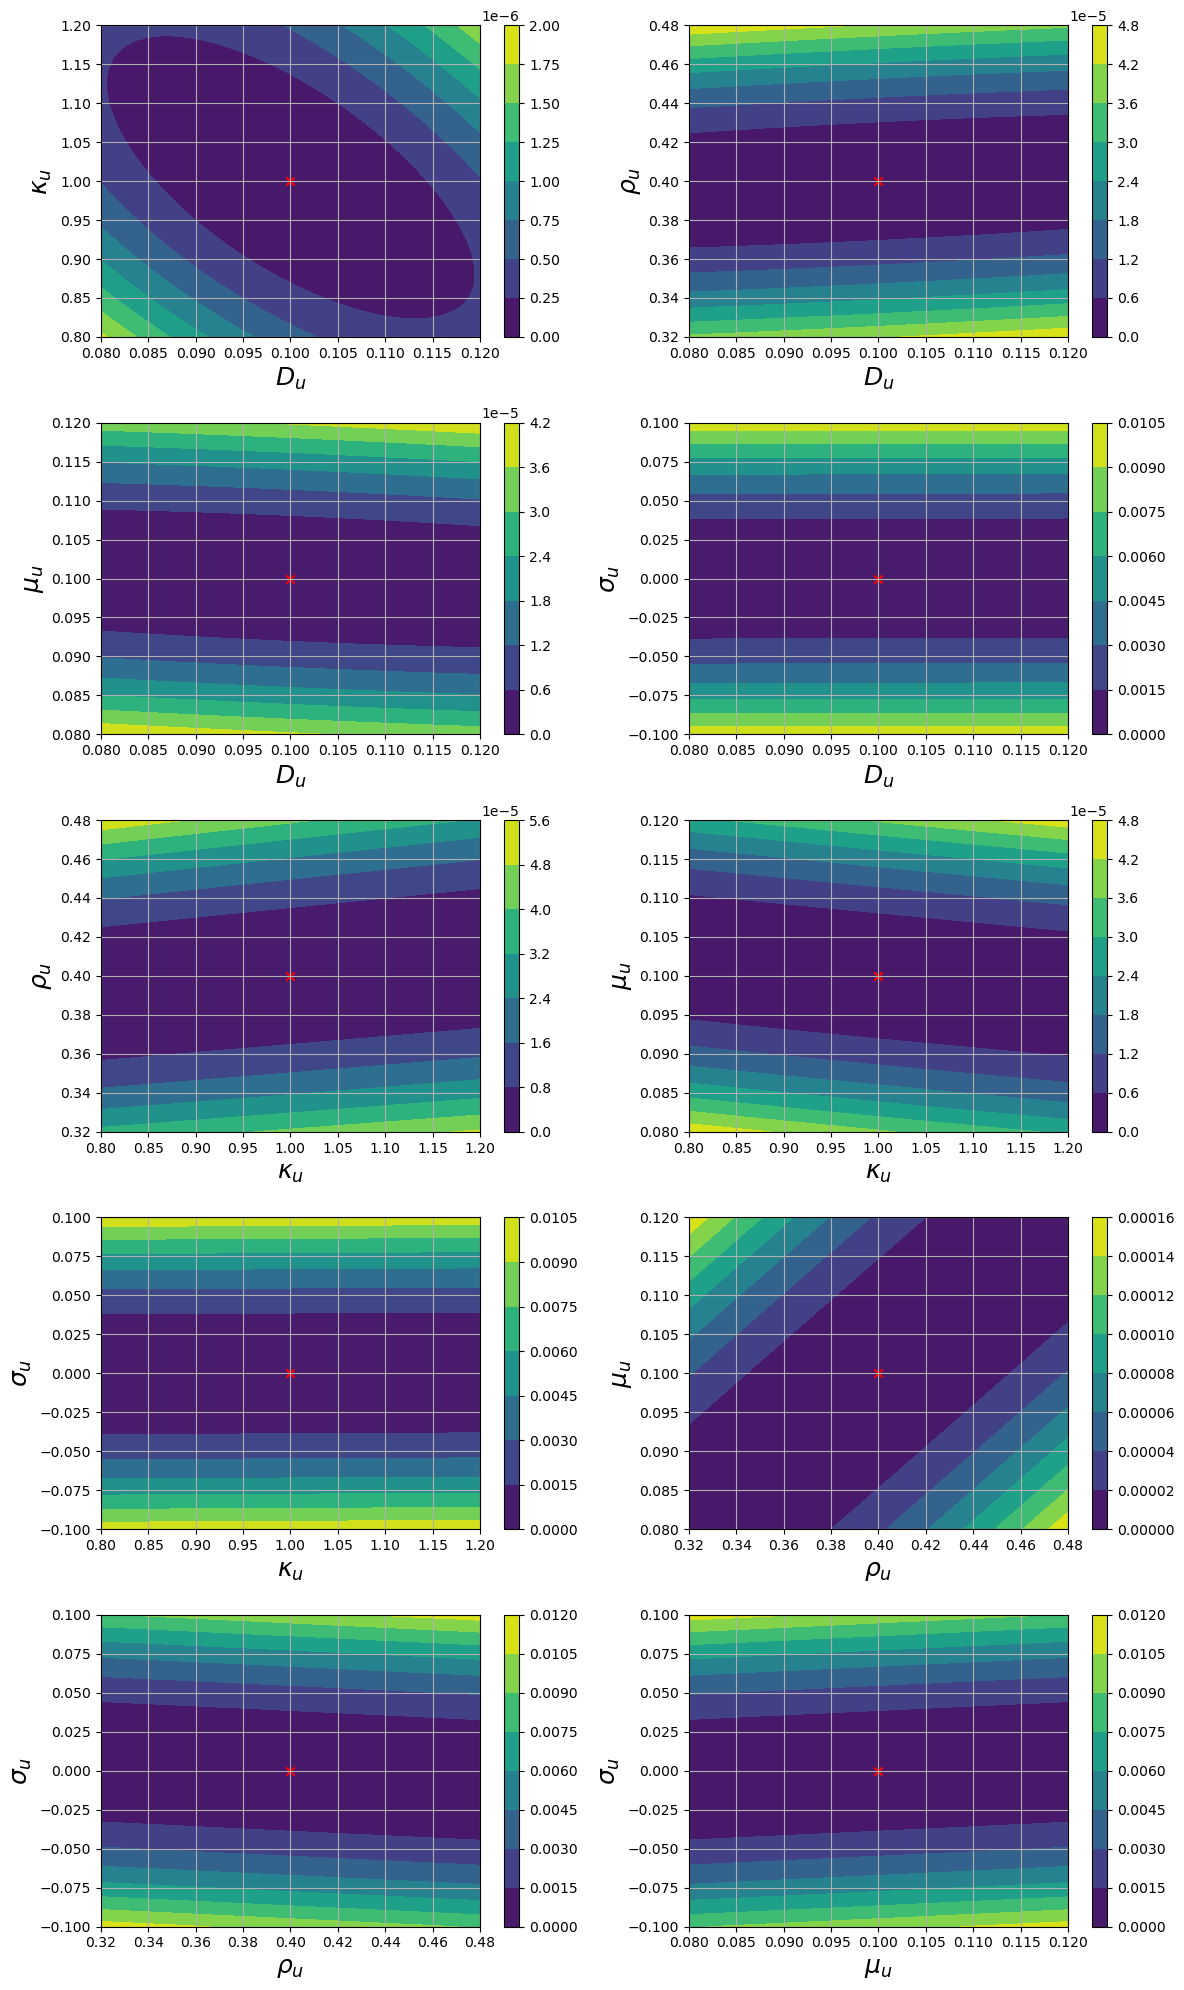

In [24]:
b_plot_u = widgets.Button(
  description="Plot u's landscape"
)

b_plot_v = widgets.Button(
  description="Plot v's landscape"
)

def disbale(value):
    b_plot_u.disabled = value
    b_plot_v.disabled = value
    
def click_plot_u(change):
    clear_output(wait=True)    
    display(l_title)
    display(hbox_plots_all)
    disbale(True)
    u_losses, u_curried_funcs = creat_all_us(pattern)
    plot_all(u_losses, u_curried_funcs, pattern.u_params)
    disbale(False)    

b_plot_u.on_click(click_plot_u)

def click_plot_v(change):
    clear_output(wait=True)
    display(l_title)
    display(hbox_plots_all)
    disbale(True)
    v_losses, v_curried_funcs = creat_all_vs(pattern)
    plot_all(v_losses, v_curried_funcs, pattern.v_params)
    disbale(False)
    
b_plot_v.on_click(click_plot_v)
##############################
l_title = widgets.Label(value=pattern.simulation.name)
hbox_plots_all = HBox([b_plot_u, b_plot_v])
display(l_title)
display(hbox_plots_all)

In [11]:
def create_zoom_range(centre,  steps=100, zoom=1.0):    
    if centre != 0:
        delta = centre/zoom
    else:
        delta = 1.0/zoom
    return np.linspace(centre-delta, centre+delta, steps+1)

def create_sliding_range(start, end, steps=100 ):
    return np.linspace(start, end, steps+1)

def param_arrays(pattern, 
                 param1, 
                 param1_zoom,
                 param2,
                 param2_zoom,
                 pattern_loss,
                 pattern_params):
    arr1 = create_zoom_range(pattern.params[param1], zoom=param1_zoom)
    arr2 = create_zoom_range(pattern.params[param2], zoom=param2_zoom)
    f = curry_func(pattern_loss, param1, param2,
                   { k:v for k, v in pattern_params.items()
                        if k != param1 and k != param2
                    })
    f_loss = res_2D(f, arr1, arr2, np.zeros((arr1.shape[0], arr2.shape[0])))
    return f_loss, (param1, arr1, param2, arr2)

def creat_single_us(pattern, 
                    param1, 
                    param1_zoom,
                    param2,
                    param2_zoom,):
    return param_arrays(pattern, 
                        param1, 
                        param1_zoom,
                        param2,
                        param2_zoom,
                        pattern.loss_u,
                        pattern.u_params)

def creat_single_vs(pattern, 
                    param1, 
                    param1_zoom,
                    param2,
                    param2_zoom,):
    return param_arrays(pattern, 
                        param1, 
                        param1_zoom,
                        param2,
                        param2_zoom,
                        pattern.loss_v,
                        pattern.v_params)


def param_sliding_arrays(param1, 
                         param1_start,
                         param1_end,
                         param2,
                         param2_start,
                         param2_end,
                         pattern_loss,
                         pattern_params):
    arr1 = create_sliding_range(param1_start, param1_end)
    arr2 = create_sliding_range(param2_start, param2_end)
    f = curry_func(pattern_loss, param1, param2,
                   { k:v for k, v in pattern_params.items()
                        if k != param1 and k != param2
                    })     
    f_loss = res_2D(f, arr1, arr2, np.zeros((arr1.shape[0], arr2.shape[0])))
    return f_loss, (param1, arr1, param2, arr2)
    
def creat_sliding_single_us(pattern, 
                     param1, 
                     param1_start,
                     param1_end,
                     param2,
                     param2_start,
                     param2_end,):
    return param_sliding_arrays(param1, 
                         param1_start,
                         param1_end,
                         param2,
                         param2_start,
                         param2_end,
                        pattern.loss_u,
                        pattern.u_params)

def creat_sliding_single_vs(pattern,  
                     param1, 
                     param1_start,
                     param1_end,
                     param2,
                     param2_start,
                     param2_end):
    return param_sliding_arrays(param1, 
                         param1_start,
                         param1_end,
                         param2,
                         param2_start,
                         param2_end,
                        pattern.loss_v,
                        pattern.v_params)

In [12]:
def plot_single(loss_val, param_ranges, params):
    _ = plt.figure(figsize=(6,4))
    (param1, arr1, param2, arr2) =  param_ranges  
    plt.contourf(arr1, arr2, loss_val)
    plt.colorbar()        
    plt.scatter(params[param1], params[param2], c='r', marker='x')
    plt.xlabel(fr'${symbols[param1]}$', fontsize=18)
    plt.ylabel(fr'${symbols[param2]}$', fontsize=18)
    #print(arr1)
    #print(arr2)
    if arr2[-1] < 0:
        plt.hlines(0, max(0, arr1[-1]), arr1[0], colors = 'r', alpha=.6)
    if arr1[-1] < 0:
        plt.vlines(0, max(0, arr2[-1]), arr2[0], colors = 'r', alpha=.6)
        
    plt.grid()
    plt.tight_layout()
    plt.show()

In [13]:
def create_range_slider(name, start=-1, end=1, min=-10, max=10, step=.1):
    return widgets.FloatRangeSlider(value=[start, end], min=min, max=max, step=step, description=name,
                                    disabled=False, continuous_update=False, orientation='horizontal',
                                    readout=True, readout_format='.2f',)

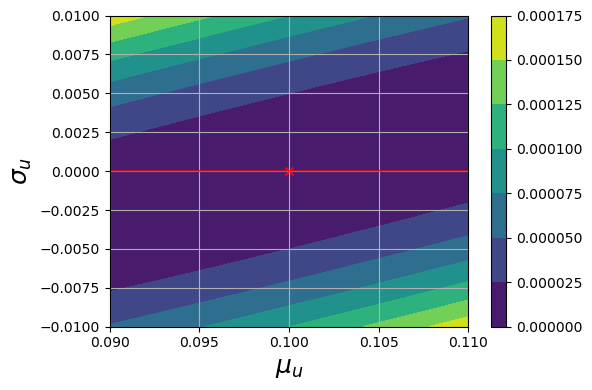

In [22]:
w_u_first_param = widgets.Dropdown(
    options=pattern.u_params.keys(),
    value="D_u",
    description='X:',
    continuous_update=False,
     readout_format='.3f',
)
w_u_second_param = widgets.Dropdown(
    options=pattern.u_params.keys(),
    value="kappa_u",
    description='Y:',
    continuous_update=False,
     readout_format='.3f',
)

b_plot_single_u = widgets.Button(
  description='Show'
)
b_change_min_max = widgets.Button(
  description='Change Min/Max'
)

w_min_max_range = widgets.IntSlider(
    value=10,
    min=1,
    max=100,
    step=1,
    description='Min/Max:',
    disabled=False,
    continuous_update=False,
)
w_min_max_step_range = widgets.FloatSlider(
    value=0.1,
    min=0.001,
    max=1,
    step=0.001,
    description='Min/Max steps:',
    disabled=False,
    continuous_update=False,
    readout_format='.3f',
)
param1_slider =  create_range_slider("X", min =-10, max=10, step=0.1)
param2_slider =  create_range_slider("Y", min =-10, max=10, step=0.1)


def disable_single_u(value):
    b_plot_single_u.disabled = value
    w_u_first_param.disabled = value
    w_u_second_param.disabled = value
    param1_slider.disabled = value
    param2_slider.disabled = value
    b_change_min_max.disabled = value
    w_min_max_range.disabled = value
    w_min_max_step_range.disabled = value
    
def click_plot_single_u(change):
    clear_output(wait=True)
    display(vbox1)
    disable_single_u(True)
    plot_single_u()
    disable_single_u(False)

def click_change_min_max(change):
    disable_single_u(True)
    param1_slider.min = -w_min_max_range.value
    param1_slider.max = w_min_max_range.value
    param1_slider.step = w_min_max_step_range.value
    param2_slider.min = -w_min_max_range.value
    param2_slider.max = w_min_max_range.value
    param2_slider.step = w_min_max_step_range.value
    disable_single_u(False)
    
def plot_single_u():
    u_loss, u_param_ranges = creat_sliding_single_us(pattern,
                                             w_u_first_param.value,
                                             param1_slider.upper,
                                             param1_slider.lower,
                                             w_u_second_param.value,
                                             param2_slider.upper,
                                             param2_slider.lower)
    plot_single(u_loss, u_param_ranges, pattern.u_params)
    
def show_u(change):
    if change['type'] == 'change' and change['name'] == 'value':        
        clear_output(wait=True)
        display(vbox1)
        disable_single_u(True)
        plot_single_u()
        disable_single_u(False)
        
b_plot_single_u.on_click(click_plot_single_u)
b_change_min_max.on_click(click_change_min_max)
#w_u_first_param.observe(show_u)
#w_u_second_param.observe(show_u)

hbox1 = HBox([w_min_max_step_range, w_min_max_range, b_change_min_max])
hbox2 = HBox([param1_slider, param2_slider])
hbox3 = HBox([w_u_first_param, w_u_second_param])
hbox4 = HBox([b_plot_single_u])
vbox1 = VBox([hbox1, hbox2, hbox3, hbox4])
display(vbox1)
#disable_single_u(True)
#plot_single_u()
#disable_single_u(False)

In [34]:
pattern.params

{'D_u': 0.1,
 'D_v': 1.0,
 'kappa_u': 1.0,
 'rho_u': 0.4,
 'mu_u': 0.1,
 'sigma_u': 0.0,
 'rho_v': 1.5,
 'sigma_v': 0.1}

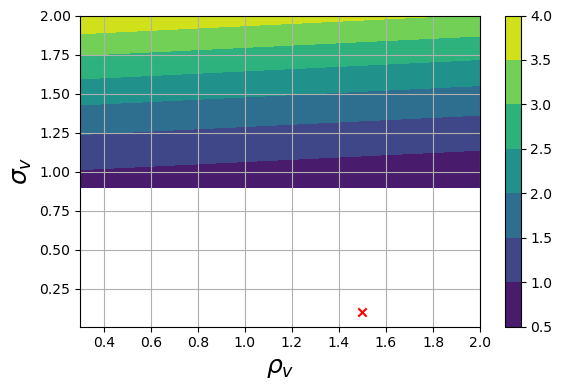

In [15]:
w_v_first_param = widgets.Dropdown(
    options=pattern.v_params.keys(),
    value="D_v",
    description='X:',
    continuous_update=False,
)
w_v_second_param = widgets.Dropdown(
    options=pattern.v_params.keys(),
    value="kappa_u",
    description='Y:',
    continuous_update=False,
)

b_plot_single_v = widgets.Button(
  description='Show'
)
b_change_min_max_v = widgets.Button(
  description='Change Min/Max'
)

w_min_max_range_v = widgets.IntSlider(
    value=10,
    min=1,
    max=100,
    step=1,
    description='Min/Max:',
    disabled=False,
    continuous_update=False,
)
w_min_max_step_range_v = widgets.FloatSlider(
    value=0.1,
    min=0.001,
    max=1,
    step=0.001,
    description='Min/Max steps:',
    disabled=False,
    continuous_update=False,
    readout_format='.3f',
)
param1_slider_v =  create_range_slider("X", min =-10, max=10, step=0.1)
param2_slider_v =  create_range_slider("Y", min =-10, max=10, step=0.1)


def disable_single_v(value):
    b_plot_single_v.disabled = value
    w_v_first_param.disabled = value
    w_v_second_param.disabled = value
    param1_slider_v.disabled = value
    param2_slider_v.disabled = value
    b_change_min_max_v.disabled = value
    w_min_max_step_range_v.disabled = value
    
def click_plot_single_v(change):
    clear_output(wait=True)
    display(vbox1_v)
    disable_single_v(True)
    plot_single_v()
    disable_single_v(False)

def click_change_min_max_v(change):
    disable_single_v(True)
    param1_slider_v.min = -w_min_max_range_v.value
    param1_slider_v.max = w_min_max_range_v.value
    param1_slider_v.step = w_min_max_step_range_v.value
    param2_slider_v.min = -w_min_max_range_v.value
    param2_slider_v.max = w_min_max_range_v.value
    param2_slider_v.step = w_min_max_step_range_v.value
    disable_single_v(False)
    
def plot_single_v():
    v_loss, v_param_ranges = creat_sliding_single_vs(pattern,
                                             w_v_first_param.value,
                                             param1_slider_v.upper,
                                             param1_slider_v.lower,
                                             w_v_second_param.value,
                                             param2_slider_v.upper,
                                             param2_slider_v.lower)
    plot_single(v_loss, v_param_ranges, pattern.v_params)
    
def show_v(change):
    if change['type'] == 'change' and change['name'] == 'value':        
        clear_output(wait=True)
        display(vbox1_v)
        disable_single_v(True)
        plot_single_v()
        disable_single_v(False)
        
b_plot_single_v.on_click(click_plot_single_v)
b_change_min_max_v.on_click(click_change_min_max_v)
#w_u_first_param.observe(show_u)
#w_u_second_param.observe(show_u)

hbox1_v = HBox([w_min_max_step_range_v, w_min_max_range_v, b_change_min_max_v])
hbox2_v = HBox([param1_slider_v, param2_slider_v])
hbox3_v = HBox([w_v_first_param, w_v_second_param])
hbox4_v = HBox([b_plot_single_v])
vbox1_v = VBox([hbox1_v, hbox2_v, hbox3_v, hbox4_v])
display(vbox1_v)
#disable_single_u(True)
#plot_single_u()
#disable_single_u(False)

[ 4.1856966e+00+0.j  3.2008253e-02+0.j  9.2434959e-05+0.j
  1.6349995e-07+0.j -1.9458490e-08+0.j  4.8124607e-06+0.j
 -2.1421707e-14+0.j -2.9874852e-18+0.j]


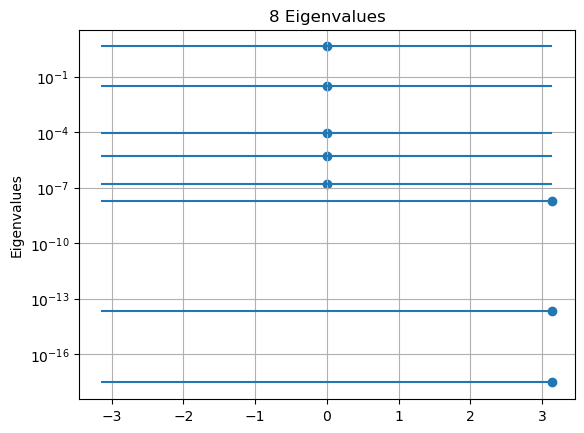

In [35]:
H = hessian(pattern.l2_loss, [i for i in range(len(pattern.params))])
H_value = jnp.array(H(pattern.params["D_u"], pattern.params["D_v"], pattern.params["kappa_u"],
                      pattern.params["rho_u"], pattern.params["mu_u"], pattern.params["sigma_u"],
                      pattern.params["rho_v"], pattern.params["sigma_v"]))
eig_vals, eig_vects = eig(H_value)
print(eig_vals)
plt.scatter(np.angle(eig_vals), np.abs(eig_vals))
for v in eig_vals:
    plt.hlines(np.abs(v), -np.pi, np.pi)

plt.title(f"{eig_vals.shape[0]} Eigenvalues")
plt.yscale('log')
plt.ylabel("Eigenvalues")
plt.grid()
plt.show()

In [36]:
def create_u_l2_loss(pattern):
    def u_l2_loss(D_u, kappa_u, rho_u, mu_u, sigma_u):
        return pattern.l2_loss(D_u, pattern.params["D_v"], kappa_u,
                               rho_u, mu_u, sigma_u,
                               pattern.params["rho_v"], pattern.params["sigma_v"])
    return u_l2_loss

def create_v_l2_loss(pattern):
    def v_l2_loss(D_v, kappa_u, rho_v, sigma_v):
        return pattern.l2_loss(pattern.params["D_u"], D_v, kappa_u,
                               pattern.params["rho_u"], pattern.params["mu_u"], pattern.params["sigma_u"],
                               rho_v, sigma_v)
    return v_l2_loss

[2.1756532e+00+0.j 2.3667695e-02+0.j 8.7107685e-05+0.j 8.2736449e-08+0.j
 4.7990393e-06+0.j]


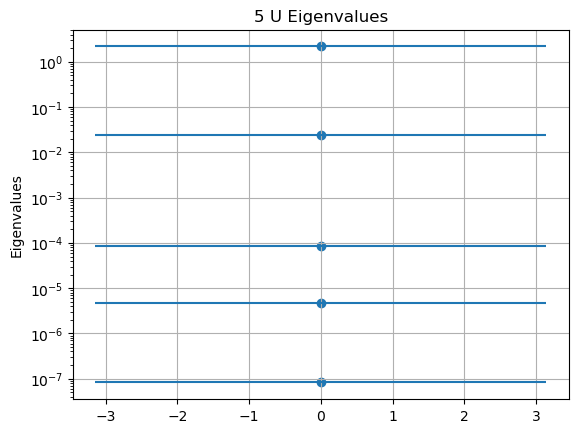

In [37]:
u_l2_loss = create_u_l2_loss(pattern)
H_u = hessian(u_l2_loss, [0, 1, 2, 3, 4])
H_u_value = jnp.array(H_u(pattern.params["D_u"], pattern.params["kappa_u"],
                          pattern.params["rho_u"], pattern.params["mu_u"], pattern.params["sigma_u"]))
u_eig_vals, u_eig_vects = eig(H_u_value)
print(u_eig_vals)
plt.scatter(np.angle(u_eig_vals), np.abs(u_eig_vals))
for val in u_eig_vals:
    plt.hlines(np.abs(val), -np.pi, np.pi)

plt.title(f"{u_eig_vals.shape[0]} U Eigenvalues")
plt.yscale('log')
plt.ylabel("Eigenvalues")
plt.grid()
plt.show()

[2.0109189e+00+0.j 7.6767700e-03+0.j 1.7553248e-08+0.j 4.9316141e-06+0.j]


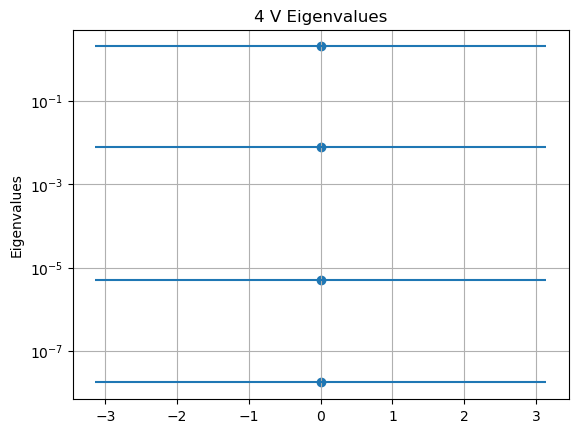

In [38]:
v_l2_loss = create_v_l2_loss(pattern)
H_v = hessian(v_l2_loss, [0, 1, 2, 3])
H_v_value = jnp.array(H_v(pattern.params["D_v"], pattern.params["kappa_u"],
                          pattern.params["rho_v"], pattern.params["sigma_v"]))
v_eig_vals, v_eig_vects = eig(H_v_value)
print(v_eig_vals)
plt.scatter(np.angle(v_eig_vals), np.abs(v_eig_vals))
for val in v_eig_vals:
    plt.hlines(np.abs(val), -np.pi, np.pi)

plt.title(f"{v_eig_vals.shape[0]} V Eigenvalues")
plt.yscale('log')
plt.ylabel("Eigenvalues")
plt.grid()
plt.show()

In [76]:
import pickle
with open("Koch_Meinhardt_2_results_data.pkl", "rb") as f:
    results_KM = pickle.load(f)

In [77]:
results_KM['rho_u']

array([1.1009742 , 1.10191822, 1.10282075, ..., 1.21230054, 1.2123009 ,
       1.21230125])

In [78]:
def plot_single_2(loss_val, param_ranges, params):
    (param1, arr1, param2, arr2) =  param_ranges  
    plt.contourf(arr1, arr2, loss_val)
    plt.colorbar()        
    #plt.scatter(params[param1], params[param2], c='r', marker='x')
    plt.xlabel(fr'${symbols[param1]}$', fontsize=18)
    plt.ylabel(fr'${symbols[param2]}$', fontsize=18)
    #print(arr1)
    #print(arr2)
    #if arr2[-1] < 0:
    #    plt.hlines(0, max(0, arr1[-1]), arr1[0], colors = 'r', alpha=.6)
    #if arr1[-1] < 0:
    #    plt.vlines(0, max(0, arr2[-1]), arr2[0], colors = 'r', alpha=.6)
        
    

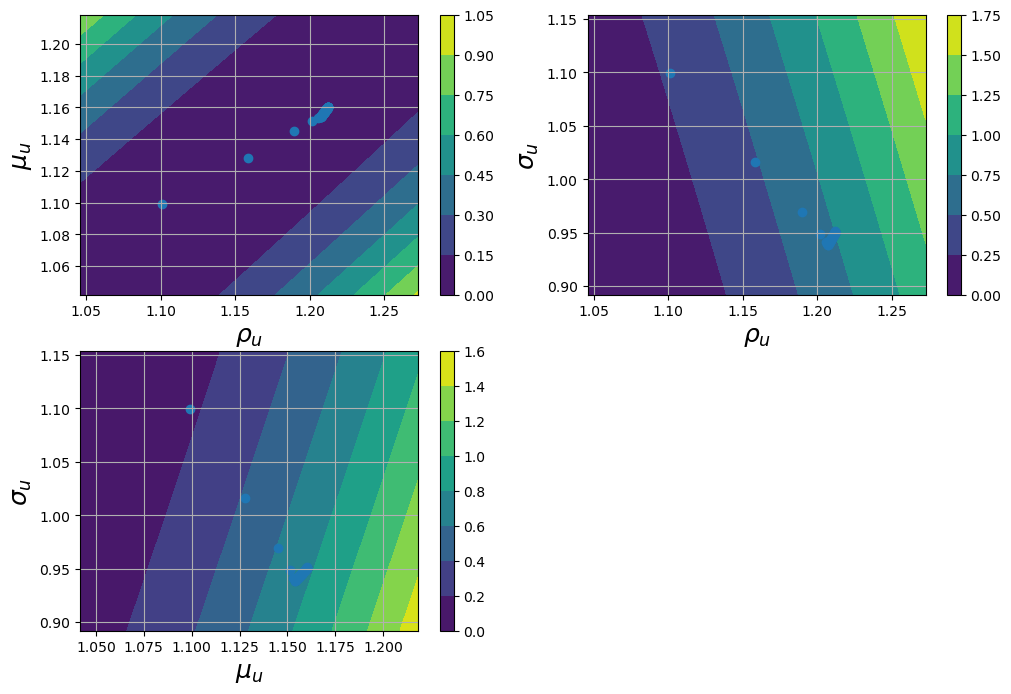

In [85]:
param1= "rho_u"
param2= "mu_u"
def plot_trajectory_u(param1, param2, pattern, results_KM):
    u_loss, u_param_ranges = creat_sliding_single_us(pattern,
                                                 param1,
                                                 np.max(results_KM[param1])*1.05,
                                                 np.min(results_KM[param1])*.95,
                                                 param2,
                                                 np.max(results_KM[param2])*1.05,
                                                 np.min(results_KM[param2])*.95,)
    plot_single_2(u_loss, u_param_ranges, pattern.u_params)
    plt.scatter(results_KM[param1][::100], results_KM[param2][::100])#, %colors = 'r')
    plt.grid()

_ = plt.figure(figsize=(12,8))
plt.subplot(221)
plot_trajectory_u("rho_u", "mu_u", pattern, results_KM)
plt.subplot(222)
plot_trajectory_u("rho_u", "sigma_u", pattern, results_KM)
plt.subplot(223)
plot_trajectory_u("mu_u", "sigma_u", pattern, results_KM)

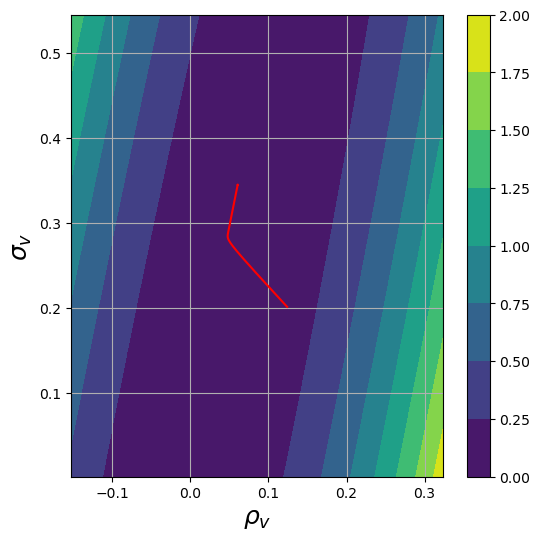

In [80]:
def plot_trajectory_v(param1, param2, pattern, results_KM):
    v_loss, v_param_ranges = creat_sliding_single_vs(pattern,
                                                 param1,
                                                 np.max(results_KM[param1]) + .2,
                                                 np.min(results_KM[param1]) - .2,
                                                 param2,
                                                 np.max(results_KM[param2]) + .2,
                                                 np.min(results_KM[param2]) - .2,)
    plot_single_2(v_loss, v_param_ranges, pattern.v_params)
    plt.plot(results_KM[param1], results_KM[param2], c = 'r')
    plt.grid()

_ = plt.figure(figsize=(6,6))
plot_trajectory_v("rho_v", "sigma_v", pattern, results_KM)


In [61]:
pattern.params

{'D_u': 0.1,
 'D_v': 1.0,
 'kappa_u': 0.0,
 'rho_u': 1.0,
 'mu_u': 1.0,
 'sigma_u': 1.0,
 'rho_v': 0.025,
 'sigma_v': 0.1}